# RSA pix2pix

We performed pixel-wise RSA encryption of the image, which is a dictionary-based and parallelized version of the algorithm.

In [1]:
import cv2
import numpy as np
import random
import os
import sys
import tqdm
import time
import matplotlib.pyplot as plt
from math import isqrt
from concurrent.futures import ThreadPoolExecutor

## Loading image
RSA.jpg is a picture with a resolution of 8K, and RSA2.jpg is a picture with a resolution of 853*1280.

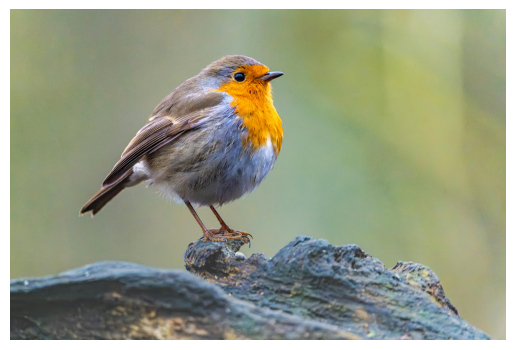

Image shape:  (5461, 8192, 3)
Max pixel value:  255


In [2]:
img = cv2.imread('RSA.jpg')
#img = cv2.imread('RSA2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, c = img.shape
plt.imshow(img)
plt.axis('off')
plt.show()
print("Image shape: ", img.shape)
# Extract the maximum pixel value
max_pixel = np.max(img)
print("Max pixel value: ", max_pixel)

In [3]:
def prime_test(n, k=100):
    s, d = 0, n - 1
    while d % 2 == 0:
        s, d = s + 1, d // 2
    for _ in range(k):
        a = random.randint(2, n - 2)
        x = pow(a, d, n)
        if x == 1 or x == n - 1:
            continue
        for _ in range(s - 1):
            x = pow(x, 2, n)
            if x == n - 1:
                break
        else:
            return False
    return True

def prime(bits):
    i = 0
    while True:
        i += 1
        p = random.getrandbits(bits)
        p |= (1 << bits - 1) | 1
        if prime_test(p):
            return p, i
        
def gcd(a, b):
    while b:
        a, b = b, a % b
    return a

def powmod(a, b, m):
    a = int(a)
    c = 1
    for _ in range(1, b):
        c = (c * a) % m
    return c

## Generate Large Prime Numbers

Alice generates two large prime numbers `p` and `q` .

In [4]:
bits = 2048
ts = time.time()
with ThreadPoolExecutor(max_workers=16) as executor:
    future_a = executor.submit(prime, bits)
    future_b = executor.submit(prime, bits)

p, pi = future_a.result()
q, qi = future_b.result()
while p == q:
    q, qii = prime(bits)
    qi += qii

print(f"prime number a generated after {pi} iterations:", p)
print(f"prime number b generated after {qi} iterations:", q)
print(f"Time taken for generate primes: {time.time() - ts:.2f} seconds")

prime number a generated after 1279 iterations: 23573636821977331048559763964300179617298322382266346610400517374220065079555686724011313442868828725731459573395420434786835992196890420055865652976850001360382519735098051926239665946325302780149200229512238407193452225672458584942462832385253146297477799580042052626569132083761935299353284974187329900683366723325614965294156726975038103308577568510396878963240270798093326018726370305401757010586603723519326518614488711849409838522499673749180384945222824452561154849279544609593735866417699486366388158855423475251296033961125786505289181918546177639396502797261797582881306208505902749066016105770403377589537
prime number b generated after 930 iterations: 31749636249290982588400661733849171381571115376717593472198042711560206831315710234217876133587678414288730935640156618232576410346954960255771369950266230103498504239011779440384158796997688884891273766666592801224375031451210661236203596566036724448565255682672386346253621409681468244

## Generate Keys

Alice generates a public key and a private key, where `(N, e)` is the public key and `(N, d)` is the private key. Alice sends her public key `(N, e)` to Bob and hides her private key `(N, d)`.

Destroy the records of `p` and `q`.

In [5]:
ts_t = time.time()
N = p * q
r = (p - 1) * (q - 1)
e = 65537
while gcd(e, r) != 1:
    e = random.randint(1, r)
d = pow(e, -1, r)
print(f"public key: ({N}, {e})")
print(f"private key: ({N}, {d})")
del p, q, r

public key: (748454394170672147576102374471895706178991839644192397838190604227663714111595925538678587026572874717296378489521547903347985308763503391087172667242491199870496899349114358273597843372556477964836627929296065700781540702195402571422904912535577348293604333078574583808834203419113876938736118027377336309689398233613473988001169357463271491086220128435116517441787076832030205081517064653038440112542979037283495001062728922925899823351162381443067545218562588632769295291527192396207162641480315971851565303547087400699748951921166789075533272517983425558086840098936090465204442747771281348166832703052656904212861954025132820353503717001524442166460889298005491091851789478518790154995801819097663284340992578994259125479342578732661581530191257765163791556747243533230687791539661587933093876076158369539607218852365570371775258158045726972640016192854975537369839845591468254579772872035234727619163483075489598914000987398571528204050469863371460924743288916202282734552887418467

## Encrypted Image


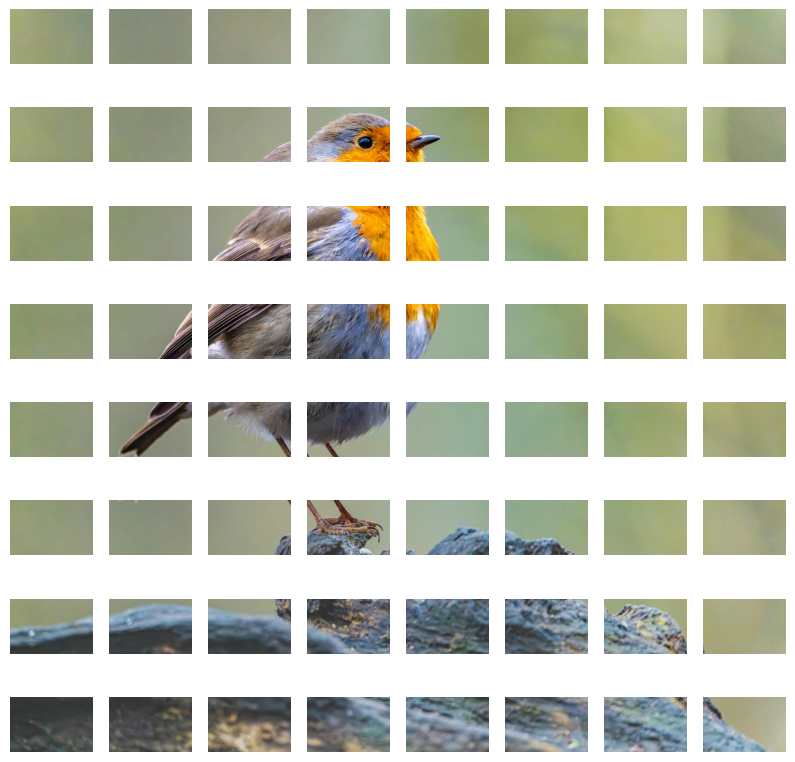

Image divided in 1.4931886196136475 seconds
Dictionary encrypted in 0.040511131286621094 seconds
Image encrypted in 16.471662759780884 seconds
Total encryption time: 18.005362510681152 seconds


In [6]:
# Divide the image into 16 parts for parallel processing.
def divide_image(img, n=4):
    h, w, c = img.shape
    img_parts = []
    for i in range(n):
        for j in range(n):
            img_parts.append(img[h//n*i:h//n*(i+1), w//n*j:w//n*(j+1)])
    return img_parts
ts = time.time()
n = 8
img_parts = divide_image(img, n,)
fig = plt.subplots(n, n, figsize=(10, 10))
for i in range(n*n):
    plt.subplot(n, n, i + 1)
    plt.imshow(img_parts[i])
    plt.axis('off')
plt.show()
print("Image divided in", time.time() - ts, "seconds")
L = N.bit_length()
l = int(max_pixel).bit_length()
if L < l:
    raise ValueError("Unable to encrypt: The number of digits in N is less than the maximum number of digits in a pixel")

def encrypt_img_part(img_part, dict_c, n):
    # ts = time.time()
    img_part_c = []
    for i in range(img_part.shape[0]):
        for j in range(img_part.shape[1]):
            for k in range(img_part.shape[2]):
                img_part_c.append(dict_c[img_part[i, j, k]])
    # print(f"part {n} encrypted in {time.time() - ts:.2f} seconds")
    return img_part_c

ts_d = time.time()
dict_c = []
for i in range(int(max_pixel) + 1):
    dict_c.append(pow(i, e, N))
print("Dictionary encrypted in", time.time() - ts_d, "seconds")

ts_e = time.time()
img_parts_c = []
with ThreadPoolExecutor(max_workers=16) as executor:
    img_parts_c = list(executor.map(lambda args: encrypt_img_part(*args), [(img_part, dict_c, i) for i, img_part in enumerate(img_parts)]))
print("Image encrypted in", time.time() - ts_e, "seconds")
print("Total encryption time:", time.time() - ts, "seconds")
del img_parts, dict_c, img

## Decrypting the image

Dictionary decrypted in 29.074764490127563 seconds
Image decrypted in 94.36785697937012 seconds


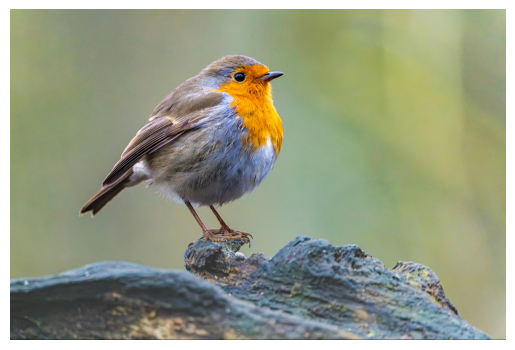

Total decryption time: 150.94104027748108 seconds
Total time taken: 169.06506419181824 seconds


In [7]:
def combine_image(img_parts, n, h, w, c):
    img_c = np.zeros((h, w, c)).astype(int)
    part_h, part_w = h // n, w // n
    for i in range(n):
        for j in range(n):
            img_c[part_h * i:part_h * (i + 1), part_w * j:part_w * (j + 1)] = np.array(img_parts[i * n + j]).reshape(part_h, part_w, c)
    return img_c

def decrypt_img_part_dict(img_part, dict_c, n):
    # ts = time.time()
    img_part_dc = []
    for i in range(len(img_part)):
        img_part_dc.append(dict_c.index(img_part[i]))
    # print(f"part {n} decrypted in {time.time() - ts:.2f} seconds")
    return img_part_dc

ts = time.time()
dict_c = set()
for img_part in img_parts_c:
    dict_c.update(img_part)
dict_c = list(dict_c)
ts_d = time.time()
dict_d = dict_c.copy()
for i in dict_c:
    dict_d[pow(i, d, N)] = i
print("Dictionary decrypted in", time.time() - ts_d, "seconds")
ts_d = time.time()
with ThreadPoolExecutor(max_workers=8) as executor:
    img_parts_dc = list(executor.map(lambda args: decrypt_img_part_dict(*args), [(img_part, dict_d, i) for i, img_part in enumerate(img_parts_c)]))
print("Image decrypted in", time.time() - ts_d, "seconds")
img_dc = combine_image(img_parts_dc, n, h, w, c)
plt.imshow(img_dc)
plt.axis('off')
plt.show()
print("Total decryption time:", time.time() - ts, "seconds")
print("Total time taken:", time.time() - ts_t, "seconds")